In [ ]:
# Movie Plot Summaries Preprocessing Script

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import ast
from sklearn.model_selection import train_test_split

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# === File Paths ===
SUMMARY_FILE = 'plot_summaries.txt'
METADATA_FILE = 'movie.metadata.tsv'

# === Initialize Tools ===
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# === Step 1: Load Plot Summaries ===
summaries = {}
with open(SUMMARY_FILE, encoding='utf-8') as f:
    for line in f:
        try:
            movie_id, summary = line.strip().split('\t', 1)
            summaries[movie_id] = summary
        except ValueError:
            continue  # skip malformed lines

# === Step 2: Load Metadata & Extract Genres ===
metadata = pd.read_csv(METADATA_FILE, sep='\t', header=None)
metadata = metadata[[0, 8]]  # Keep only movie_id and genre
metadata.columns = ['movie_id', 'genres']
metadata['movie_id'] = metadata['movie_id'].astype(str)  # Match type with summaries

# Parse genre stringified dictionaries to lists
def parse_genres(g):
    try:
        genre_dict = ast.literal_eval(g)
        return list(genre_dict.values())
    except:
        return []

metadata['genres'] = metadata['genres'].apply(parse_genres)

# === Step 3: Combine Metadata with Summaries ===
data = pd.DataFrame({'movie_id': list(summaries.keys()), 'summary': list(summaries.values())})
merged = pd.merge(data, metadata, on='movie_id')
merged.dropna(subset=['genres', 'summary'], inplace=True)

# === Step 4: Clean the Summaries for ML Use ===
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # remove punctuation & digits
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    return ' '.join(tokens)

merged['cleaned_summary'] = merged['summary'].apply(clean_text)

# === Step 5: Final Output with Both Summaries ===
final_df = merged[['movie_id', 'summary', 'cleaned_summary', 'genres']]
final_df.to_csv('cleaned_movie_dataset.csv', index=False)

# === Step 6: Train-Test Split ===
train_df, test_df = train_test_split(final_df, test_size=0.2, random_state=42)
train_df.to_csv('train_data.csv', index=False)
test_df.to_csv('test_data.csv', index=False)

# === Completion Message ===
print("✅ Preprocessing complete. Files saved:")
print(" - cleaned_movie_dataset.csv")
print(" - train_data.csv")
print(" - test_data.csv")
print("Total movies processed:", len(final_df))


[nltk_data] Downloading package stopwords to C:\Users\Muhammad Azan
[nltk_data]     Afzal\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to C:\Users\Muhammad Azan
[nltk_data]     Afzal\AppData\Roaming\nltk_data...


✅ Preprocessing complete. Files saved:
 - cleaned_movie_dataset.csv
 - train_data.csv
 - test_data.csv
Total movies processed: 42207


In [5]:
# TRANSLATE_SUMMARY
!pip install deep-translator


In [ ]:
# Translate summaries to Arabic, Urdu, and Korean

import pandas as pd
from deep_translator import GoogleTranslator
import time

# Load the cleaned dataset
df = pd.read_csv("cleaned_movie_dataset.csv")

# Limit to first 50 entries for performance and audio later
df = df.head(50)

# Translation targets
languages = ['ar', 'ur', 'ko']  # Arabic, Urdu, Korean
language_names = {'ar': 'arabic', 'ur': 'urdu', 'ko': 'korean'}

# Initialize empty columns
for lang_code in languages:
    df[f'summary_{lang_code}'] = ""

# Translate summaries
for i, row in df.iterrows():
    original = row['cleaned_summary']
    for lang_code in languages:
        try:
            translated = GoogleTranslator(source='auto', target=lang_code).translate(original)
            df.at[i, f'summary_{lang_code}'] = translated
            time.sleep(1.5)  # avoid rate limit
        except Exception as e:
            print(f"Translation error at row {i} for {lang_code}: {e}")
            df.at[i, f'summary_{lang_code}'] = "Translation Failed"

# Save the result
df.to_csv("translated_summaries.csv", index=False)
print("✅ Translation completed. Saved as translated_summaries.csv")

Translation error at row 26 for ar: villager new big city bhagwaan turn crime avoid starvation drawn gang slum crime lord dada shambu fall every crime one violence woman impoverished honourable young widow hang raped shambu dada cry orphaned baby awaken bhagwaans soul rebel former master bhagwaan vow atone formerly evil life adopts orphaned baby son innocent young boy becomes bhagwaans source personal redemption inspiration year later man lovingly hailed bhagwaan dada transformed former crimeridden slum safe happy neighbourhood shantinagar adopted son govinda become pride joy whole community despite dark past loving father worked hard raise boy good person sound moral value time bhagwaan chance rescue another nave young man new big city swaroop shambu dada gang steal swaroops money impressed swaroops education well similarity situation arrival city year bhagwaan take innocent simple villager protective wing arranges good job even brings swaroop home live son young govinda swaroop bhagw

In [ ]:
#AUDIO_GENERATION

In [ ]:
# Generate audio files from translated summaries

import pandas as pd
from gtts import gTTS
import os
import time

# Load the translated summaries
df = pd.read_csv("translated_summaries.csv")

# Language mapping for gTTS
lang_map = {
    'ar': 'Arabic',
    'ur': 'Urdu',
    'ko': 'Korean'
}

# Make output directory if it doesn't exist
os.makedirs("audio", exist_ok=True)

# Loop through each row and language
for i, row in df.iterrows():
    movie_id = row['movie_id']
    for lang_code in ['ar', 'ur', 'ko']:
        text = row[f'summary_{lang_code}']
        if text != "Translation Failed" and isinstance(text, str) and text.strip():
            retries = 3
            while retries > 0:
                try:
                    tts = gTTS(text=text, lang=lang_code)
                    filename = f"audio/movie_{movie_id}_{lang_code}.mp3"
                    tts.save(filename)
                    print(f"✅ Audio saved: {filename}")
                    time.sleep(5)  # Increased delay
                    break
                except Exception as e:
                    if "429" in str(e):
                        print(f"⚠️ Rate limit hit. Retrying for movie {movie_id} in {lang_map[lang_code]}...")
                        time.sleep(10)  # Wait longer before retrying
                        retries -= 1
                    else:
                        print(f"❌ Audio generation failed for movie {movie_id} in {lang_map[lang_code]}: {e}")
                        break
            else:
                print(f"❌ Failed after retries for movie {movie_id} in {lang_map[lang_code]}")
        else:
            print(f"⚠️ Skipped audio for movie {movie_id} in {lang_map[lang_code]} (empty or failed translation)")

print("\n✅ Audio generation complete. All files saved in the 'audio' folder.")


In [ ]:
'''✅ Audio saved: audio/movie_23890098_ar.mp3
✅ Audio saved: audio/movie_23890098_ur.mp3
✅ Audio saved: audio/movie_23890098_ko.mp3
✅ Audio saved: audio/movie_31186339_ar.mp3
✅ Audio saved: audio/movie_31186339_ur.mp3
✅ Audio saved: audio/movie_31186339_ko.mp3
✅ Audio saved: audio/movie_20663735_ar.mp3
✅ Audio saved: audio/movie_20663735_ur.mp3
✅ Audio saved: audio/movie_20663735_ko.mp3
✅ Audio saved: audio/movie_2231378_ar.mp3
✅ Audio saved: audio/movie_2231378_ur.mp3
✅ Audio saved: audio/movie_2231378_ko.mp3
✅ Audio saved: audio/movie_595909_ar.mp3
✅ Audio saved: audio/movie_595909_ur.mp3
✅ Audio saved: audio/movie_595909_ko.mp3
✅ Audio saved: audio/movie_5272176_ar.mp3
✅ Audio saved: audio/movie_5272176_ur.mp3
✅ Audio saved: audio/movie_5272176_ko.mp3
✅ Audio saved: audio/movie_1952976_ar.mp3
✅ Audio saved: audio/movie_1952976_ur.mp3
✅ Audio saved: audio/movie_1952976_ko.mp3
✅ Audio saved: audio/movie_24225279_ar.mp3
✅ Audio saved: audio/movie_24225279_ur.mp3
✅ Audio saved: audio/movie_24225279_ko.mp3
✅ Audio saved: audio/movie_2462689_ar.mp3
✅ Audio saved: audio/movie_2462689_ur.mp3
✅ Audio saved: audio/movie_2462689_ko.mp3
✅ Audio saved: audio/movie_20532852_ar.mp3
✅ Audio saved: audio/movie_20532852_ur.mp3
✅ Audio saved: audio/movie_20532852_ko.mp3
✅ Audio saved: audio/movie_15401493_ar.mp3
✅ Audio saved: audio/movie_15401493_ur.mp3
✅ Audio saved: audio/movie_15401493_ko.mp3
✅ Audio saved: audio/movie_18188932_ar.mp3
✅ Audio saved: audio/movie_18188932_ur.mp3
✅ Audio saved: audio/movie_18188932_ko.mp3
✅ Audio saved: audio/movie_2940516_ar.mp3
✅ Audio saved: audio/movie_2940516_ur.mp3
✅ Audio saved: audio/movie_2940516_ko.mp3
✅ Audio saved: audio/movie_1335380_ar.mp3
✅ Audio saved: audio/movie_1335380_ur.mp3
✅ Audio saved: audio/movie_1335380_ko.mp3
⚠️ Skipped audio for movie 1480747 in Arabic (empty or failed translation)
⚠️ Skipped audio for movie 1480747 in Urdu (empty or failed translation)
⚠️ Skipped audio for movie 1480747 in Korean (empty or failed translation)
✅ Audio saved: audio/movie_24448645_ar.mp3
✅ Audio saved: audio/movie_24448645_ur.mp3
✅ Audio saved: audio/movie_24448645_ko.mp3
✅ Audio saved: audio/movie_15072401_ar.mp3
✅ Audio saved: audio/movie_15072401_ur.mp3
✅ Audio saved: audio/movie_15072401_ko.mp3
✅ Audio saved: audio/movie_4018288_ar.mp3
✅ Audio saved: audio/movie_4018288_ur.mp3
✅ Audio saved: audio/movie_4018288_ko.mp3
✅ Audio saved: audio/movie_4596602_ar.mp3
✅ Audio saved: audio/movie_4596602_ur.mp3
✅ Audio saved: audio/movie_4596602_ko.mp3
✅ Audio saved: audio/movie_15224586_ar.mp3
✅ Audio saved: audio/movie_15224586_ur.mp3
✅ Audio saved: audio/movie_15224586_ko.mp3
✅ Audio saved: audio/movie_15585766_ar.mp3
✅ Audio saved: audio/movie_15585766_ur.mp3
✅ Audio saved: audio/movie_15585766_ko.mp3
✅ Audio saved: audio/movie_1760737_ar.mp3
✅ Audio saved: audio/movie_1760737_ur.mp3
✅ Audio saved: audio/movie_1760737_ko.mp3
✅ Audio saved: audio/movie_29062594_ar.mp3
✅ Audio saved: audio/movie_29062594_ur.mp3
✅ Audio saved: audio/movie_29062594_ko.mp3
✅ Audio saved: audio/movie_29326153_ar.mp3
✅ Audio saved: audio/movie_29326153_ur.mp3
✅ Audio saved: audio/movie_29326153_ko.mp3
✅ Audio saved: audio/movie_9252321_ar.mp3
✅ Audio saved: audio/movie_9252321_ur.mp3
✅ Audio saved: audio/movie_9252321_ko.mp3
✅ Audio saved: audio/movie_8388648_ar.mp3
✅ Audio saved: audio/movie_8388648_ur.mp3
✅ Audio saved: audio/movie_8388648_ko.mp3
⚠️ Skipped audio for movie 10644072 in Arabic (empty or failed translation)
⚠️ Skipped audio for movie 10644072 in Urdu (empty or failed translation)
⚠️ Skipped audio for movie 10644072 in Korean (empty or failed translation)
✅ Audio saved: audio/movie_13455076_ar.mp3
✅ Audio saved: audio/movie_13455076_ur.mp3
✅ Audio saved: audio/movie_13455076_ko.mp3
✅ Audio saved: audio/movie_33269085_ar.mp3
✅ Audio saved: audio/movie_33269085_ur.mp3
✅ Audio saved: audio/movie_33269085_ko.mp3
✅ Audio saved: audio/movie_2254491_ar.mp3
✅ Audio saved: audio/movie_2254491_ur.mp3
✅ Audio saved: audio/movie_2254491_ko.mp3
✅ Audio saved: audio/movie_447194_ar.mp3
✅ Audio saved: audio/movie_447194_ur.mp3
✅ Audio saved: audio/movie_447194_ko.mp3
✅ Audio saved: audio/movie_24165951_ar.mp3
✅ Audio saved: audio/movie_24165951_ur.mp3
✅ Audio saved: audio/movie_24165951_ko.mp3
✅ Audio saved: audio/movie_18549958_ar.mp3
✅ Audio saved: audio/movie_18549958_ur.mp3
✅ Audio saved: audio/movie_18549958_ko.mp3
✅ Audio saved: audio/movie_12978934_ar.mp3
✅ Audio saved: audio/movie_12978934_ur.mp3
✅ Audio saved: audio/movie_12978934_ko.mp3
✅ Audio saved: audio/movie_8471210_ar.mp3
✅ Audio saved: audio/movie_8471210_ur.mp3
✅ Audio saved: audio/movie_8471210_ko.mp3
✅ Audio saved: audio/movie_1925869_ar.mp3
✅ Audio saved: audio/movie_1925869_ur.mp3
✅ Audio saved: audio/movie_1925869_ko.mp3
✅ Audio saved: audio/movie_10799612_ar.mp3
✅ Audio saved: audio/movie_10799612_ur.mp3
✅ Audio saved: audio/movie_10799612_ko.mp3
✅ Audio saved: audio/movie_3150865_ar.mp3
✅ Audio saved: audio/movie_3150865_ur.mp3
✅ Audio saved: audio/movie_3150865_ko.mp3
✅ Audio saved: audio/movie_20591333_ar.mp3
✅ Audio saved: audio/movie_20591333_ur.mp3
✅ Audio saved: audio/movie_20591333_ko.mp3
✅ Audio saved: audio/movie_28238240_ar.mp3
✅ Audio saved: audio/movie_28238240_ur.mp3
✅ Audio saved: audio/movie_28238240_ko.mp3
⚠️ Skipped audio for movie 5414895 in Arabic (empty or failed translation)
⚠️ Skipped audio for movie 5414895 in Urdu (empty or failed translation)
⚠️ Skipped audio for movie 5414895 in Korean (empty or failed translation)
✅ Audio saved: audio/movie_17124781_ar.mp3
✅ Audio saved: audio/movie_17124781_ur.mp3
✅ Audio saved: audio/movie_17124781_ko.mp3
✅ Audio saved: audio/movie_5425205_ar.mp3
✅ Audio saved: audio/movie_5425205_ur.mp3
✅ Audio saved: audio/movie_5425205_ko.mp3
✅ Audio saved: audio/movie_28207941_ar.mp3
✅ Audio saved: audio/movie_28207941_ur.mp3
✅ Audio saved: audio/movie_28207941_ko.mp3
✅ Audio saved: audio/movie_14330027_ar.mp3
✅ Audio saved: audio/movie_14330027_ur.mp3
✅ Audio saved: audio/movie_14330027_ko.mp3
✅ Audio saved: audio/movie_4356664_ar.mp3
✅ Audio saved: audio/movie_4356664_ur.mp3
✅ Audio saved: audio/movie_4356664_ko.mp3
✅ Audio saved: audio/movie_19174305_ar.mp3
✅ Audio saved: audio/movie_19174305_ur.mp3
✅ Audio saved: audio/movie_19174305_ko.mp3
✅ Audio saved: audio/movie_33417831_ar.mp3
✅ Audio saved: audio/movie_33417831_ur.mp3
✅ Audio saved: audio/movie_33417831_ko.mp3
✅ Audio saved: audio/movie_2408359_ar.mp3
✅ Audio saved: audio/movie_2408359_ur.mp3
✅ Audio saved: audio/movie_2408359_ko.mp3
✅ Audio saved: audio/movie_1838882_ar.mp3
✅ Audio saved: audio/movie_1838882_ur.mp3
✅ Audio saved: audio/movie_1838882_ko.mp3

✅ Audio generation complete. All files saved in the 'audio' folder.'''

In [9]:
#MODEL_TRAINING
!pip install sentence-transformers


Batches:   0%|          | 0/2049 [00:00<?, ?it/s]

Batches:   0%|          | 0/514 [00:00<?, ?it/s]


📊 Classification Report (Top Genres):
                        precision    recall  f1-score   support

                Action       0.50      0.80      0.61      1759
             Animation       0.34      0.86      0.49       495
       Black-and-white       0.21      0.76      0.33       735
                Comedy       0.52      0.71      0.60      2426
         Crime Fiction       0.33      0.79      0.47       911
        Crime Thriller       0.14      0.81      0.24       296
           Documentary       0.25      0.86      0.39       254
                 Drama       0.66      0.72      0.69      3889
           Family Film       0.26      0.77      0.38       607
               Fantasy       0.18      0.80      0.29       402
       Film adaptation       0.08      0.66      0.14       264
                Horror       0.41      0.84      0.55       812
                 Indie       0.15      0.66      0.25       715
       Japanese Movies       0.21      0.82      0.33       266


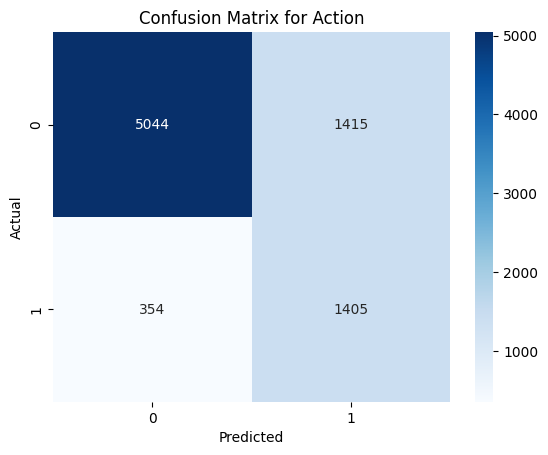

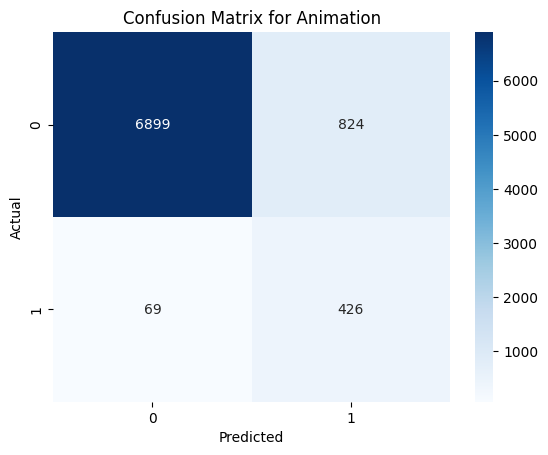

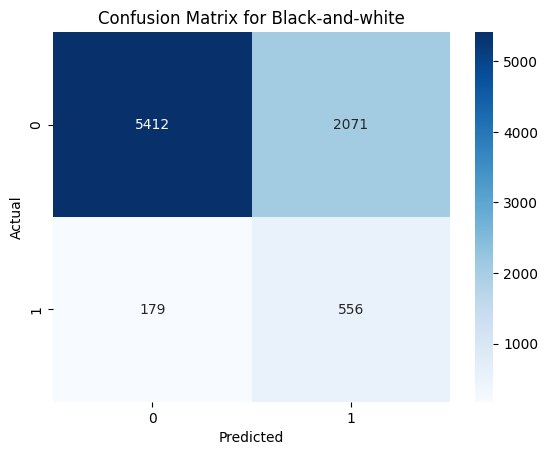

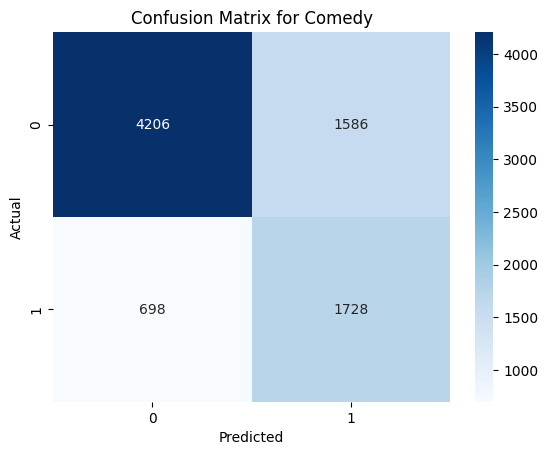

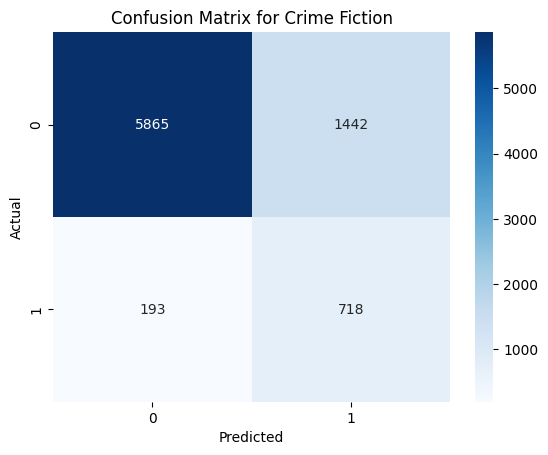

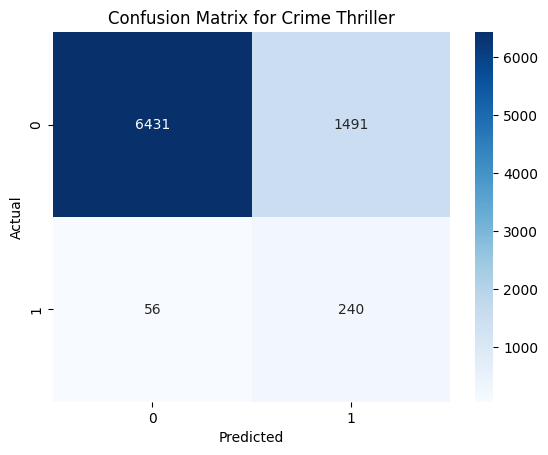

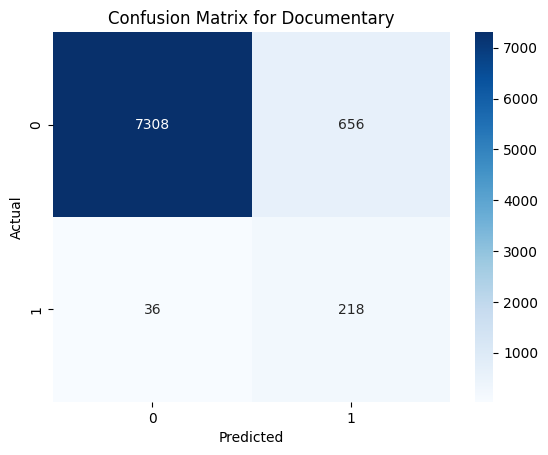

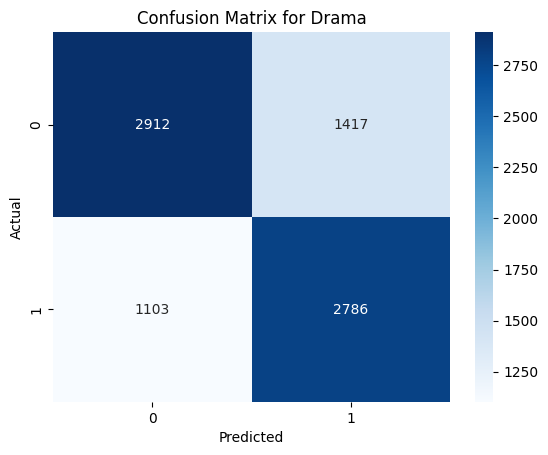

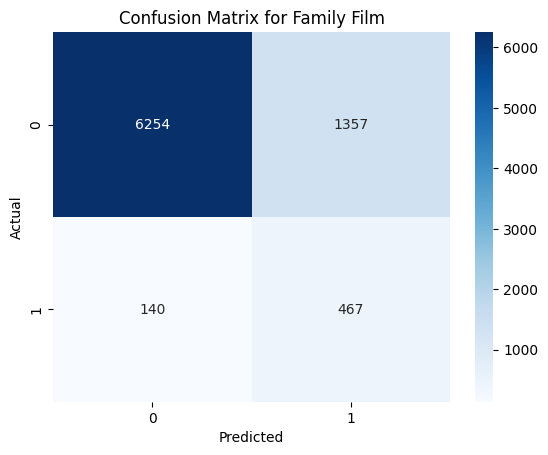

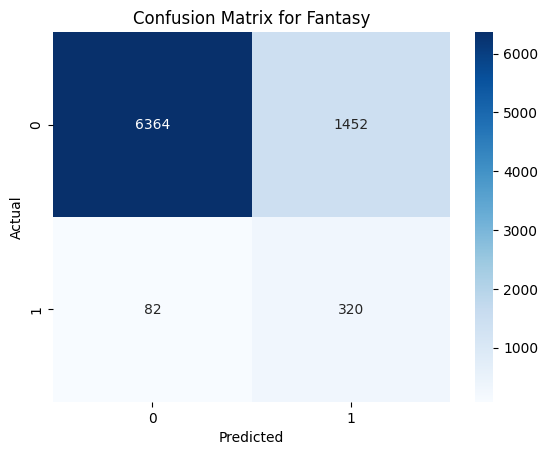

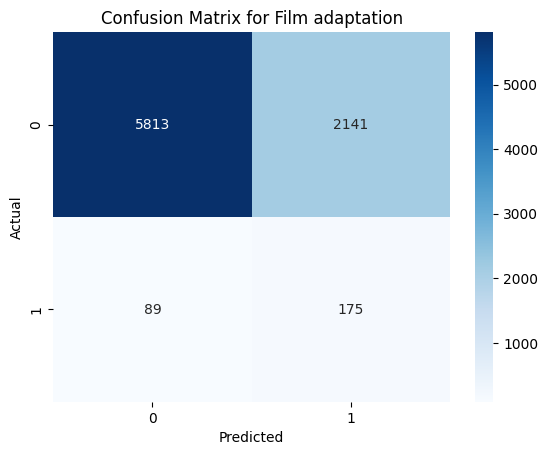

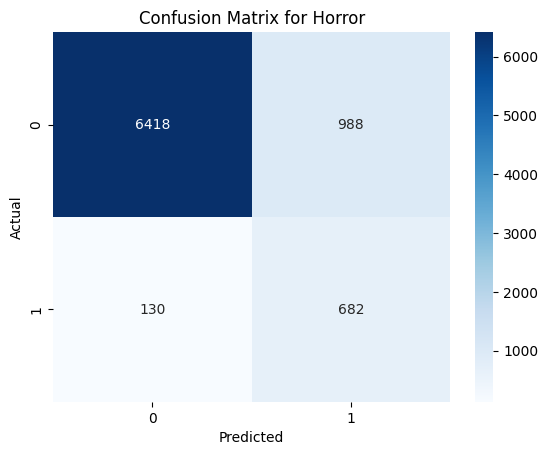

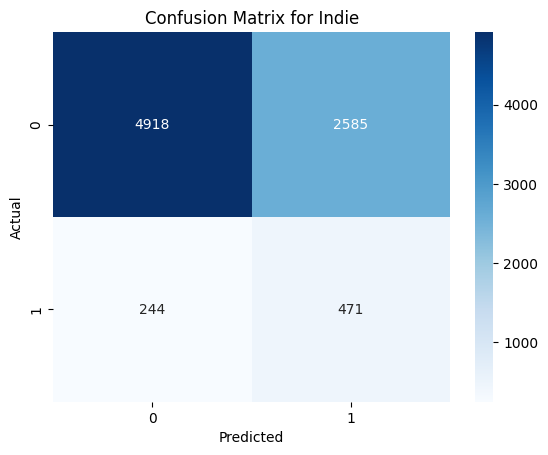

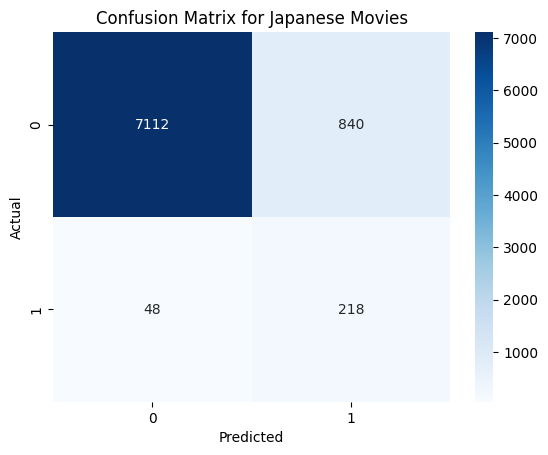

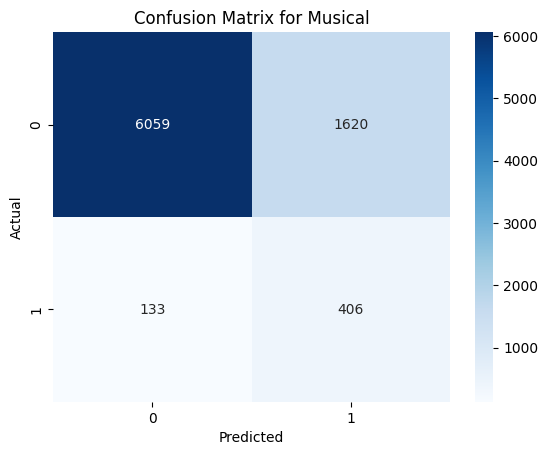

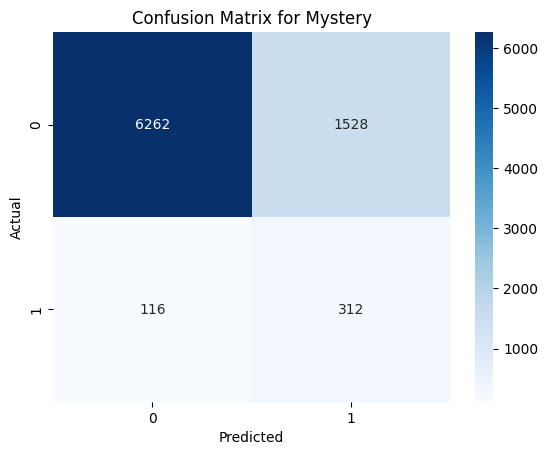

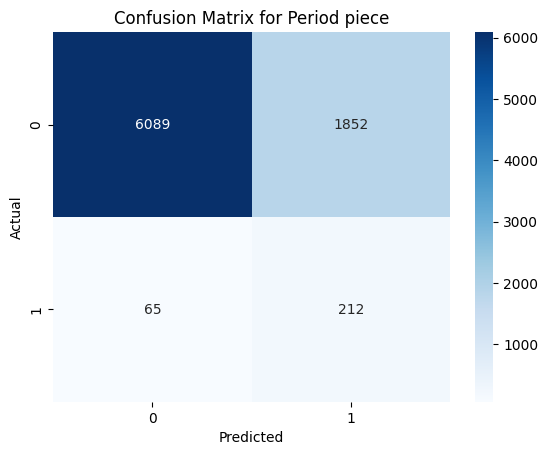

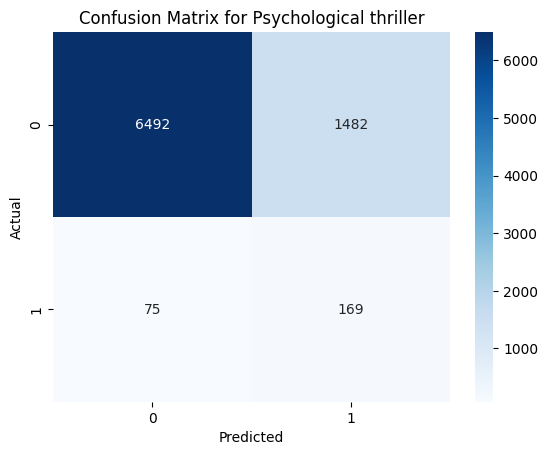

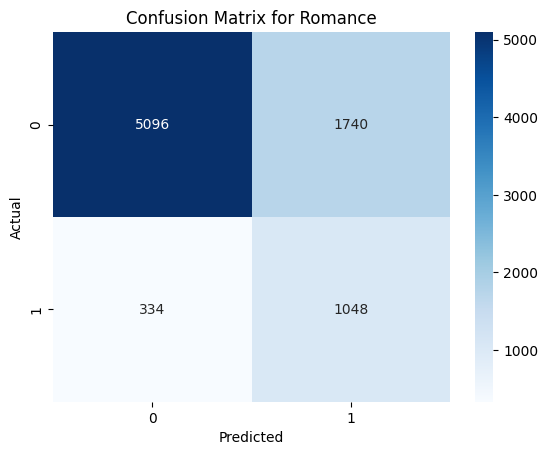

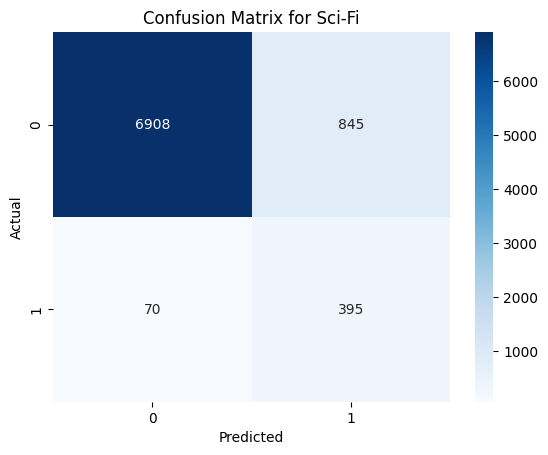

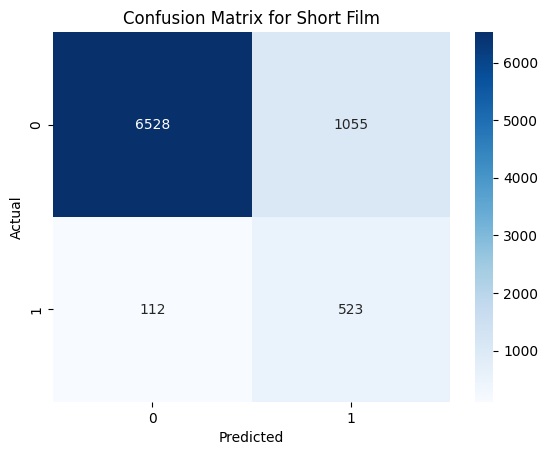

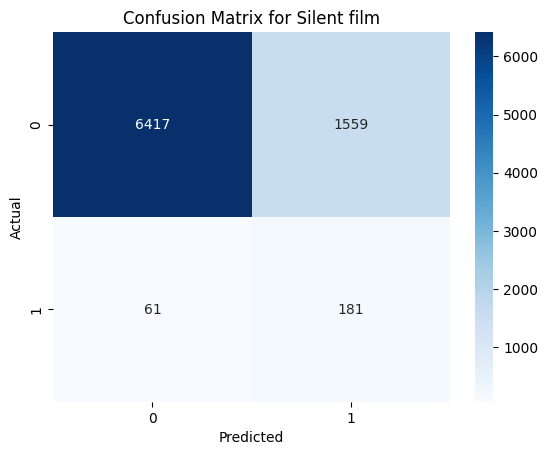

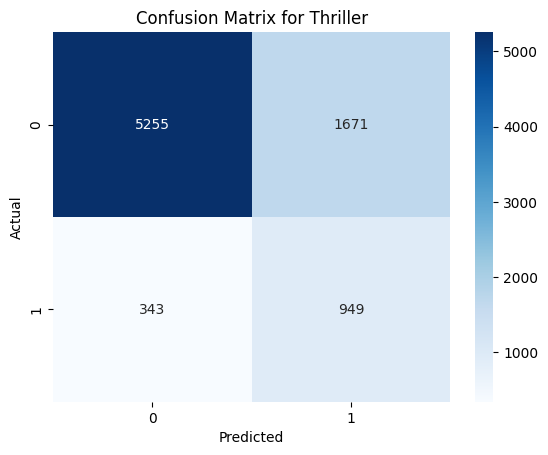

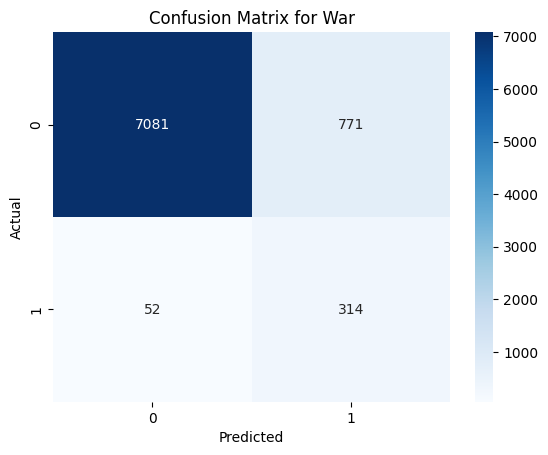

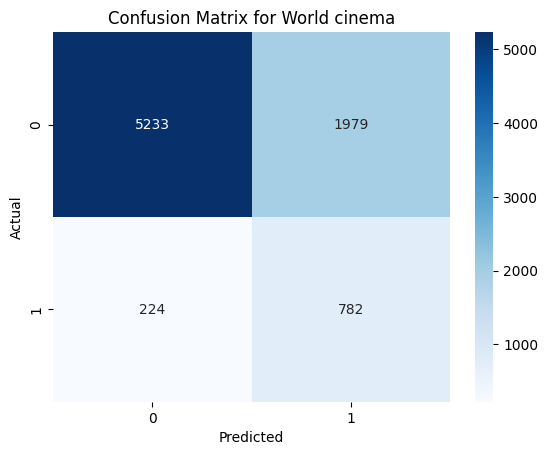

['label_binarizer_cleaned.pkl']

In [ ]:
# Train a multi-label classification model on the cleaned dataset

import pandas as pd
import numpy as np
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, accuracy_score, multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import ast
from collections import Counter

# Load datasets
train_df = pd.read_csv("train_data.csv")
test_df = pd.read_csv("test_data.csv")

train_df["genres"] = train_df["genres"].apply(ast.literal_eval)
test_df["genres"] = test_df["genres"].apply(ast.literal_eval)

# Genre merging map
genre_merge_map = {
    "Romantic drama": "Romance", "Romantic comedy": "Romance", "Romance Film": "Romance",
    "Science Fiction": "Sci-Fi", "Sci-Fi Adventure": "Sci-Fi", "Sci-Fi Horror": "Sci-Fi", 
    "Action/Adventure": "Action", "Action Thrillers": "Action", "Adventure": "Action", "Adventure Comedy": "Action",
    "Comedy film": "Comedy", "Comedy-drama": "Comedy", "Black comedy": "Comedy", 
    "Musical Drama": "Musical", "Musical comedy": "Musical", "Music": "Musical", 
    "Horror Comedy": "Horror", "Slasher": "Horror", "Psychological horror": "Horror",
    "War film": "War", "Historical drama": "War", "Historical Epic": "War"
}

def merge_genres(genres):
    merged = []
    for g in genres:
        if g in genre_merge_map:
            merged.append(genre_merge_map[g])
        else:
            merged.append(g)
    return list(set(merged))

train_df["genres"] = train_df["genres"].apply(merge_genres)
test_df["genres"] = test_df["genres"].apply(merge_genres)

# Keep only top 25 genres
all_genres = sum(train_df["genres"], [])
top_genres = [g for g, _ in Counter(all_genres).most_common(25)]

def filter_top_genres(genres):
    return [g for g in genres if g in top_genres]

train_df["genres"] = train_df["genres"].apply(filter_top_genres)
test_df["genres"] = test_df["genres"].apply(filter_top_genres)

train_df = train_df[train_df["genres"].map(len) > 0]
test_df = test_df[test_df["genres"].map(len) > 0]

# Sentence embedding
model = SentenceTransformer("all-MiniLM-L6-v2")
X_train = model.encode(train_df["cleaned_summary"].tolist(), show_progress_bar=True, batch_size=16)
X_test = model.encode(test_df["cleaned_summary"].tolist(), show_progress_bar=True, batch_size=16)

# Labels
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(train_df["genres"])
y_test = mlb.transform(test_df["genres"])


# Train classifier
classifier = OneVsRestClassifier(LogisticRegression(max_iter=1000, class_weight="balanced"))
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

# Evaluation
print("\n📊 Classification Report (Top Genres):")
print(classification_report(y_test, y_pred, target_names=mlb.classes_))
print(f"✅ Accuracy: {accuracy_score(y_test, y_pred):.4f}")

conf_matrices = multilabel_confusion_matrix(y_test, y_pred)
for i, label in enumerate(mlb.classes_):
    sns.heatmap(conf_matrices[i], annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for {label}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Save model
joblib.dump(classifier, "genre_classifier_cleaned.pkl")
joblib.dump(mlb, "label_binarizer_cleaned.pkl")


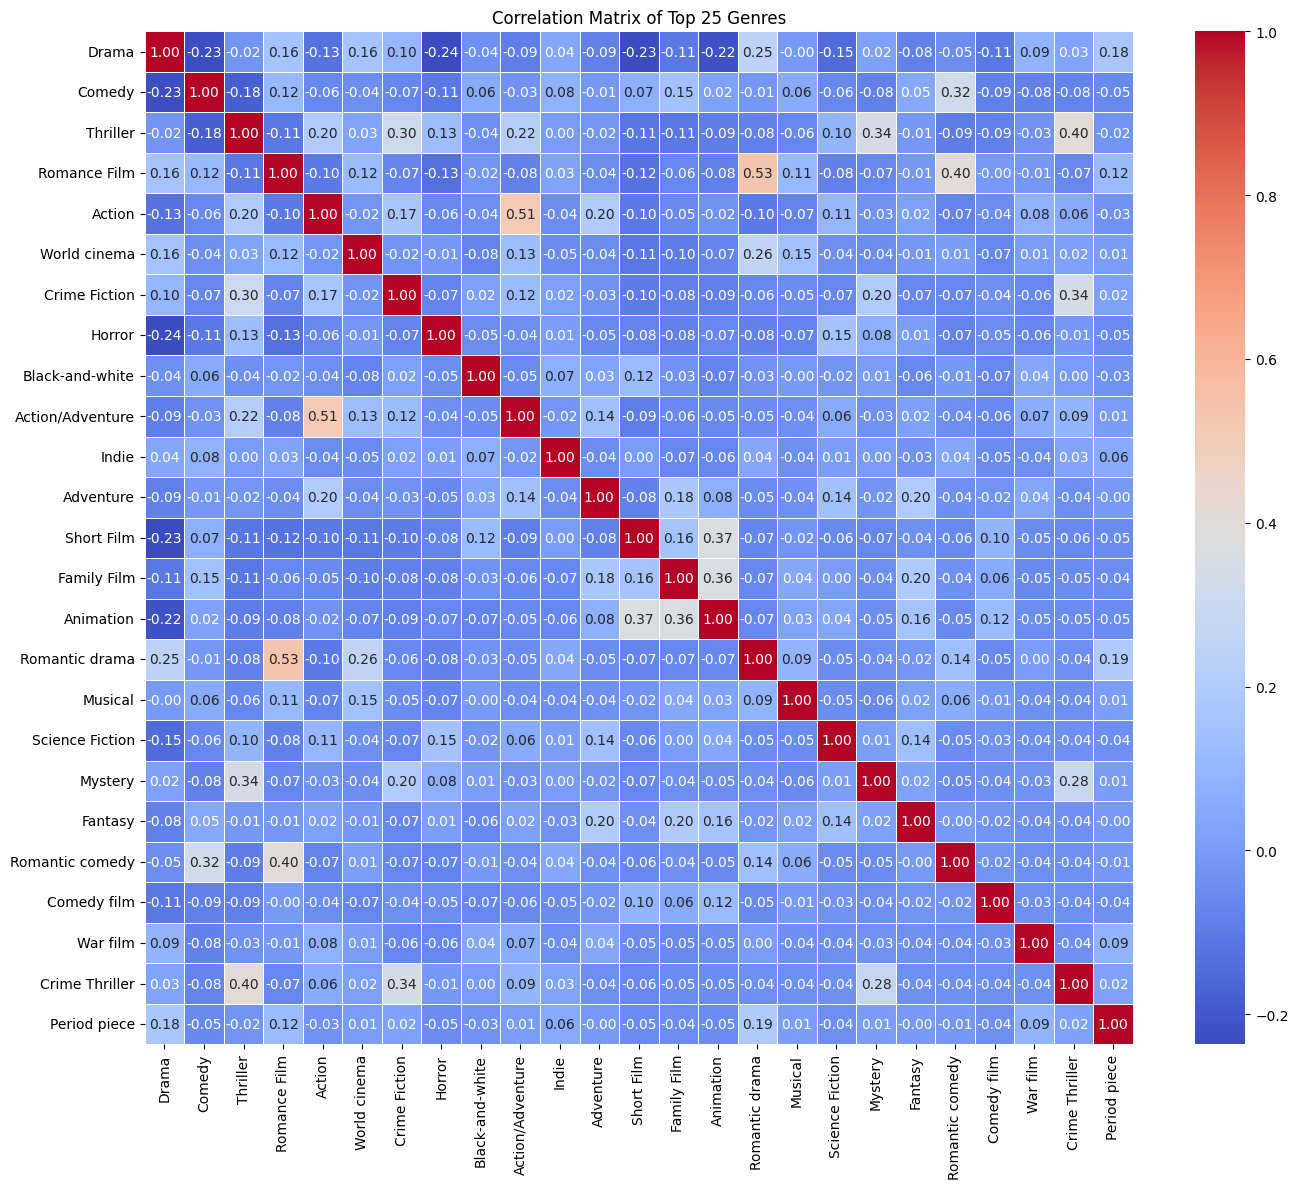

In [ ]:
# === Genre Correlation Analysis ===

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
import ast
from collections import Counter

# Load test dataset
test_df = pd.read_csv("test_data.csv")
test_df["genres"] = test_df["genres"].apply(ast.literal_eval)

# Flatten all genres and count frequencies
all_genres = sum(test_df["genres"], [])
top_genres = [g for g, _ in Counter(all_genres).most_common(25)]

# Keep only top 25 genres
def filter_top_25(genres):
    return [g for g in genres if g in top_genres]

test_df["genres"] = test_df["genres"].apply(filter_top_25)
test_df = test_df[test_df["genres"].map(len) > 0]

# Binarize labels
mlb = MultiLabelBinarizer(classes=top_genres)
y_test = mlb.fit_transform(test_df["genres"])

# Create DataFrame from binarized labels
df_genres = pd.DataFrame(y_test, columns=mlb.classes_)

# Compute correlation matrix
correlation_matrix = df_genres.corr()

# Plot heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Top 25 Genres")
plt.tight_layout()
plt.show()

In [ ]:
# TESTING

import pandas as pd
import joblib
from sentence_transformers import SentenceTransformer
from sklearn.metrics import hamming_loss
import ast

# Load test data
test_df = pd.read_csv("test_data.csv")
test_df["genres"] = test_df["genres"].apply(ast.literal_eval)

# Filter empty genre rows
test_df = test_df[test_df["genres"].map(len) > 0]

# Load model and label binarizer
classifier = joblib.load("genre_classifier_cleaned.pkl")
mlb = joblib.load("label_binarizer_cleaned.pkl")

# Load SBERT model for encoding
model = SentenceTransformer("all-MiniLM-L6-v2")

# Encode test summaries
X_test = model.encode(test_df["cleaned_summary"].tolist(), show_progress_bar=True, batch_size=16)

# Transform labels
y_test = mlb.transform(test_df["genres"])

# Predict and calculate Hamming Loss
y_pred = classifier.predict(X_test)
hloss = hamming_loss(y_test, y_pred)

print(f"✅ Hamming Loss: {hloss:.4f}")

Batches:   0%|          | 0/524 [00:00<?, ?it/s]

c:\Users\Muhammad Azan Afzal\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:909: UserWarning: unknown class(es) ['Absurdism', 'Acid western', 'Action Comedy', 'Action Thrillers', 'Action/Adventure', 'Addiction Drama', 'Adult', 'Adventure', 'Adventure Comedy', 'Airplanes and airports', 'Albino bias', 'Alien Film', 'Alien invasion', 'Americana', 'Animal Picture', 'Animals', 'Animated Musical', 'Animated cartoon', 'Anime', 'Anti-war', 'Anti-war film', 'Apocalyptic and post-apocalyptic fiction', 'Archaeology', 'Art film', 'Auto racing', 'Avant-garde', 'B-Western', 'B-movie', 'Backstage Musical', 'Baseball', 'Beach Film', 'Bengali Cinema', 'Biker Film', 'Biographical film', 'Biography', 'Biopic [feature]', 'Black comedy', 'Blaxploitation', 'Bollywood', 'Boxing', 'Breakdance', 'British Empire Film', 'British New Wave', 'Buddy cop', 'Buddy film', 'Camp', 'Caper story', 'Cavalry Film', 'Chase Movie', 'Childhood Drama', "Children's", "Children's Entert

✅ Hamming Loss: 0.2102


In [1]:
!pip install pandas matplotlib seaborn scikit-learn numpy fpdf


  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40770 sha256=eec84294a0bf424b70378213c7ad410c20b7df0ec93d9ee4aa64f308cef079f4
  Stored in directory: c:\users\muhammad azan afzal\appdata\local\pip\cache\wheels\aa\da\11\a3189f34ddc13c26a2d0f329eac46b728c7f31c39e4dc26243
Successfully built fpdf


C:\Users\Muhammad Azan Afzal\AppData\Local\Temp\ipykernel_9880\3703974462.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x=metric, y='Genre', palette=color)
C:\Users\Muhammad Azan Afzal\AppData\Local\Temp\ipykernel_9880\3703974462.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x=metric, y='Genre', palette=color)
C:\Users\Muhammad Azan Afzal\AppData\Local\Temp\ipykernel_9880\3703974462.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x=metric, y='Genre', palette=color)


'/mnt/data/Full_Genre_Classification_Report.pdf'

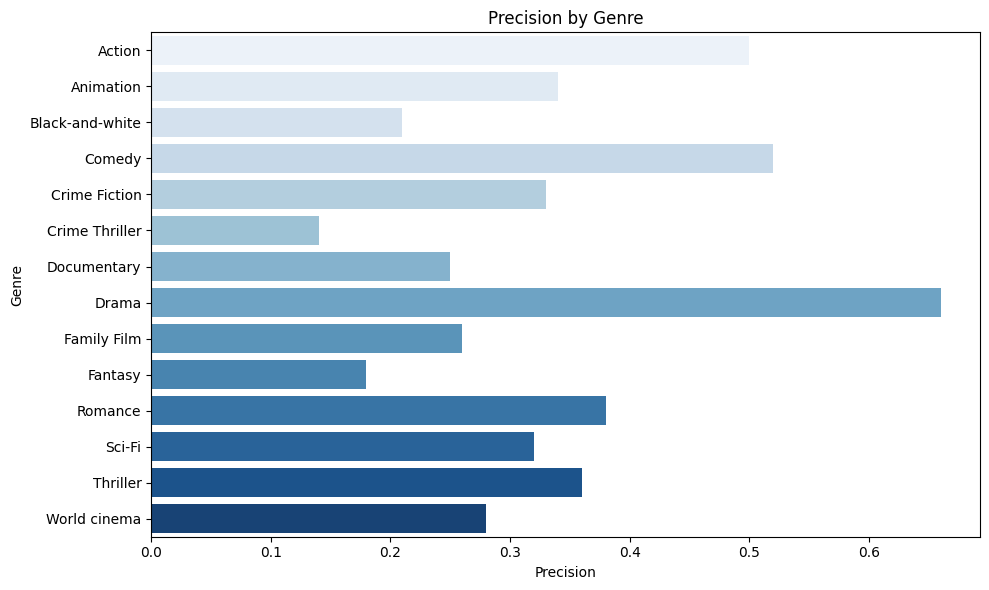

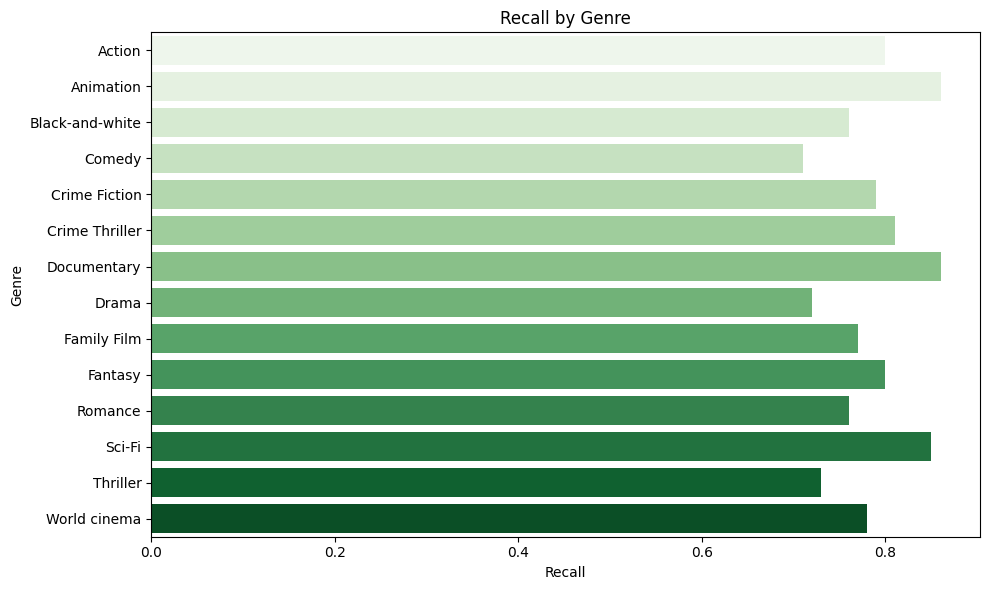

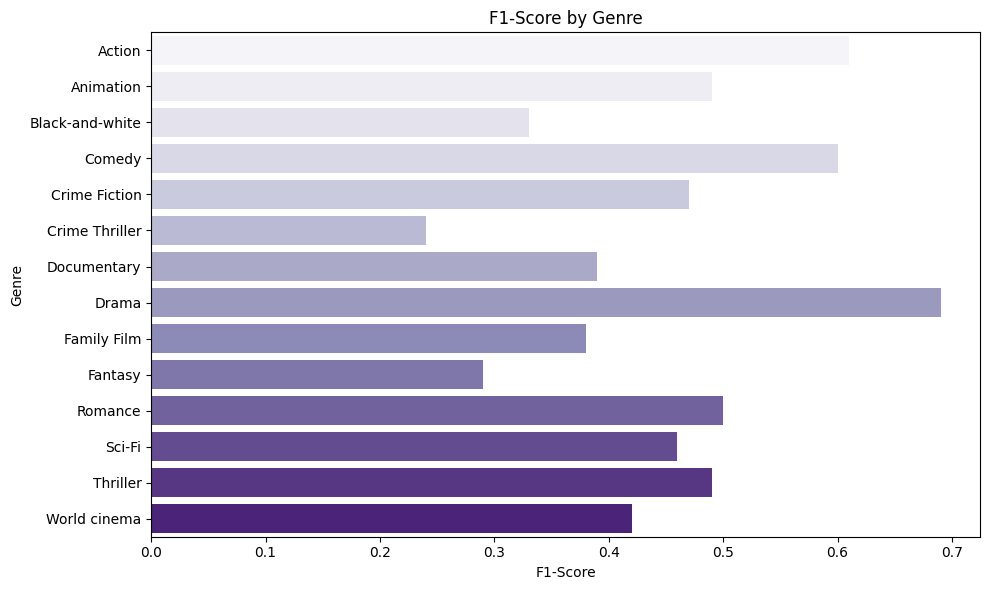

In [ ]:
# Generate classification report and save as PDF

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import numpy as np
from fpdf import FPDF
import os

# Load classification report from a dictionary (simulate)
report_dict = {
    'Action': {'precision': 0.50, 'recall': 0.80, 'f1-score': 0.61, 'support': 1759},
    'Animation': {'precision': 0.34, 'recall': 0.86, 'f1-score': 0.49, 'support': 495},
    'Black-and-white': {'precision': 0.21, 'recall': 0.76, 'f1-score': 0.33, 'support': 735},
    'Comedy': {'precision': 0.52, 'recall': 0.71, 'f1-score': 0.60, 'support': 2426},
    'Crime Fiction': {'precision': 0.33, 'recall': 0.79, 'f1-score': 0.47, 'support': 911},
    'Crime Thriller': {'precision': 0.14, 'recall': 0.81, 'f1-score': 0.24, 'support': 296},
    'Documentary': {'precision': 0.25, 'recall': 0.86, 'f1-score': 0.39, 'support': 254},
    'Drama': {'precision': 0.66, 'recall': 0.72, 'f1-score': 0.69, 'support': 3889},
    'Family Film': {'precision': 0.26, 'recall': 0.77, 'f1-score': 0.38, 'support': 607},
    'Fantasy': {'precision': 0.18, 'recall': 0.80, 'f1-score': 0.29, 'support': 402},
    'Romance': {'precision': 0.38, 'recall': 0.76, 'f1-score': 0.50, 'support': 1382},
    'Sci-Fi': {'precision': 0.32, 'recall': 0.85, 'f1-score': 0.46, 'support': 465},
    'Thriller': {'precision': 0.36, 'recall': 0.73, 'f1-score': 0.49, 'support': 1292},
    'World cinema': {'precision': 0.28, 'recall': 0.78, 'f1-score': 0.42, 'support': 1006}
}

# Convert to DataFrame
df = pd.DataFrame(report_dict).T.reset_index().rename(columns={'index': 'Genre'})

# Plotting
def plot_metric(metric, df, color):
    # Ensure the directory exists
    output_dir = '/mnt/data/'
    os.makedirs(output_dir, exist_ok=True)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x=metric, y='Genre', palette=color)
    plt.title(f'{metric.title()} by Genre')
    plt.xlabel(metric.title())
    plt.ylabel('Genre')
    plt.tight_layout()
    path = os.path.join(output_dir, f'{metric}_chart.png')
    plt.savefig(path)
    return path

precision_path = plot_metric('precision', df, 'Blues')
recall_path = plot_metric('recall', df, 'Greens')
f1_path = plot_metric('f1-score', df, 'Purples')

# Generate PDF
pdf = FPDF()
pdf.add_page()
pdf.set_font("Arial", 'B', 16)
pdf.cell(0, 10, "Genre Classification Report", ln=True, align='C')

for metric, path in [('Precision', precision_path), ('Recall', recall_path), ('F1-Score', f1_path)]:
    pdf.set_font("Arial", 'B', 12)
    pdf.cell(0, 10, f"{metric} Chart", ln=True)
    pdf.image(path, w=180)
    pdf.ln(10)

pdf_path = "/mnt/data/Full_Genre_Classification_Report.pdf"
pdf.output(pdf_path)

pdf_path